In [1]:
import ROOT
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

Welcome to JupyROOT 6.24/00


In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
def plot(listA, listB, xlabel='', ylabel='', EvsE = True):
    fig = plt.figure(figsize=(7,7))
    plt.scatter(listA, listB, s=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if(EvsE):
        axes = plt.gca()    
        axes.set_xlim([0,350])
        axes.set_ylim([0,350])
        plt.axline((150,150), (400,400))

def color2Dplot(x, y, z, xlabel='', ylabel='', zlabel='', title=''):
    plt.figure(figsize=(10,6))
    points = plt.scatter(x, y, c=z, cmap='jet',lw=0, s=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(points)
    cbar.set_label(zlabel)
    
def MakeDataFrame(inputFile):
    f = uproot.open(inputFile)
    tree = f[inputFile.split('/')[-1].replace('.root','')]
    df = tree.arrays(library="pd")
    df['Tot1x1_1'] = df['EM1x1_1'] + df['Had1x1_1']
    df['Tot3x3_1'] = df['EM3x3_1'] + df['Had3x3_1']
    df['Tot5x5_1'] = df['EM5x5_1'] + df['Had5x5_1']
    df['Tot7x7_1'] = df['EM7x7_1'] + df['Had7x7_1']
    df['Tot9x9_1'] = df['EM9x9_1'] + df['Had9x9_1']
    df['Tot11x11_1'] = df['EM11x11_1'] + df['Had11x11_1']

    df['Tot1x1_2'] = df['EM1x1_2'] + df['Had1x1_2']
    df['Tot3x3_2'] = df['EM3x3_2'] + df['Had3x3_2']
    df['Tot5x5_2'] = df['EM5x5_2'] + df['Had5x5_2']
    df['Tot7x7_2'] = df['EM7x7_2'] + df['Had7x7_2']
    df['Tot9x9_2'] = df['EM9x9_2'] + df['Had9x9_2']
    df['Tot11x11_2'] = df['EM11x11_2'] + df['Had11x11_2']    

    df['GenFullEnergy_1'] = df['GenEnergy_1']*np.cosh(df['GenEta_1'])
    df['GenFullEnergy_2'] = df['GenEnergy_2']*np.cosh(df['GenEta_2'])
    
    return df

def getEdges(distFromEdge):
    """
    distFromEdge is the number of eta bins to discard from high and low eta edge of the HGC
    """
    EtaCutHigh = (35 - distFromEdge) * 0.087
    EtaCutLow = (15 + distFromEdge) * 0.087
    return(EtaCutLow, EtaCutHigh)

In [4]:
df_WithSplit = MakeDataFrame('varsDir/vars_VBFHToInv_NoPU_WithEnergySplit.root')
df_NoSplit = MakeDataFrame('varsDir/vars_VBFHToInv_NoPU_NoEnergySplit.root')

/vols/cms/mhh18/volsb/miniconda/miniconda3/envs/myenv/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in cosh
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_WithSplit_0binsfromEdge_1 = df_WithSplit[(abs(df_WithSplit['GenEta_1'])>getEdges(0)[0]) & (abs(df_WithSplit['GenEta_1'])<getEdges(0)[1])]
df_NoSplit_0binsfromEdge_1 = df_NoSplit[(abs(df_NoSplit['GenEta_1'])>getEdges(0)[0]) & (abs(df_NoSplit['GenEta_1'])<getEdges(0)[1])]

In [6]:
df_With = df_WithSplit_0binsfromEdge_1
df_No = df_NoSplit_0binsfromEdge_1

In [13]:
thresholds = np.array([20, 40, 60, 80, 100, 120, 150, 350])
variables = ['Tot1x1_1', 'Tot3x3_1', 'Tot5x5_1', 'Tot7x7_1', 'Tot9x9_1', 'Tot11x11_1']

for df in ['df_With', 'df_No']:
    for var in variables:
        exec(df + "Dic"  + var + " = {'mean':[], 'std':[]}")
        exec(df + "DicRatio" + var + " = {'mean':[], 'std':[]}")
        for i in range(len(thresholds)-1):
            exec("data = " + df + "[(" + df + "['GenEnergy_1']>thresholds[i]) & (" + df + "['GenEnergy_1']<thresholds[i+1])]")
            exec(df + "Dic" + var + "['mean'].append(data[var].mean())")
            exec(df + "Dic" + var + "['std'].append(data[var].std())")
            exec(df + "DicRatio" + var + "['mean'].append((data[var]/data['GenEnergy_1']).mean())")
            exec(df + "DicRatio" + var + "['std'].append((data[var]/data['GenEnergy_1']).std())")

In [15]:
midEnergies = np.array([ 0.5*(thresholds[i]+thresholds[i+1]) for i in range(len(thresholds)-1)])
errEnergies = np.array([ midEnergies[i]-thresholds[i] for i in range(len(midEnergies))])

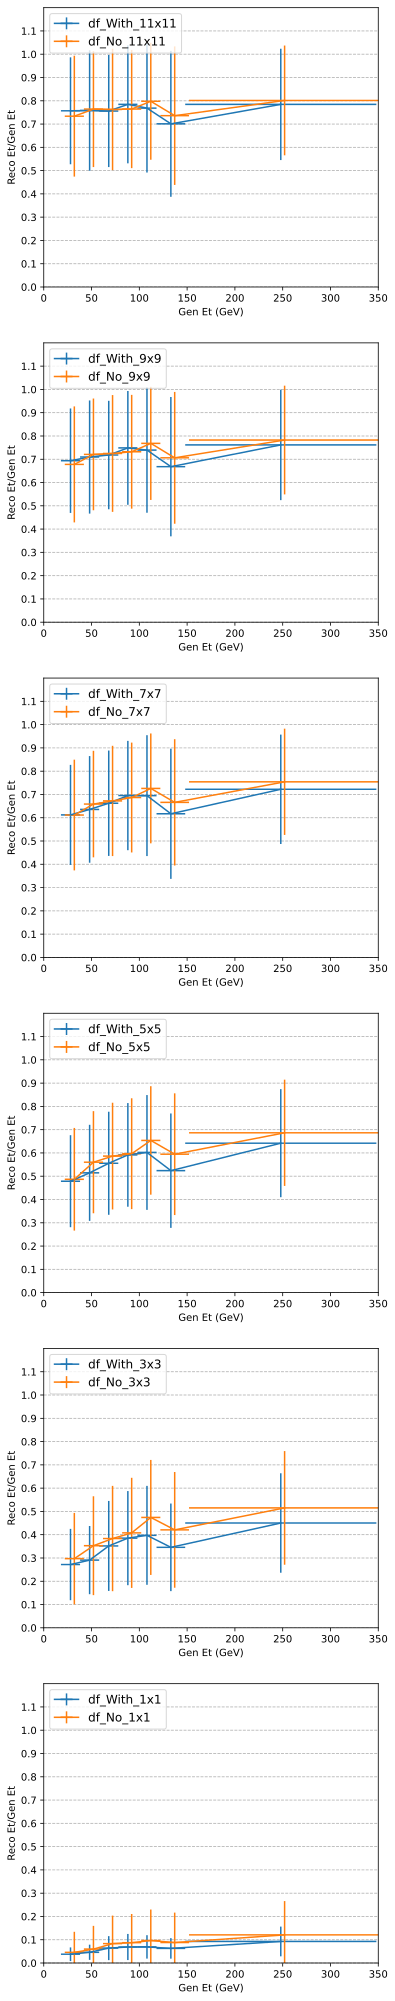

In [36]:
fig, axes = plt.subplots(6, figsize=(6,36))
alphaC=1

for index, var in enumerate(reversed(variables)):
    offSet = -2
    for df in ['df_With', 'df_No']:
        exec("axes[index].errorbar(midEnergies+offSet,"+df+"DicRatio"+var+"['mean'], xerr=errEnergies, yerr="+df+"dicRatio"+var+"['std'], label='"+df +'_'+var.replace('Tot','').replace('_1','')+ "', alpha=alphaC)")
        offSet+=4
    axes[index].legend(loc='upper left', fontsize=12)
    axes[index].set_xlabel('Gen Et (GeV)')
    axes[index].set_ylabel('Reco Et/Gen Et')
    axes[index].set_xlim([0,350])
    axes[index].set_ylim([0,1.2])
    axes[index].set_yticks(np.arange(0, 1.2, 0.1))
    axes[index].grid(axis='y', linestyle='--')

In [37]:
df_With

,GenEnergy_1,GenEta_1,GenPhi_1,EM1x1_1,EM3x3_1,EM5x5_1,EM7x7_1,EM9x9_1,EM11x11_1,Had1x1_1,...,Tot9x9_1,Tot11x11_1,Tot1x1_2,Tot3x3_2,Tot5x5_2,Tot7x7_2,Tot9x9_2,Tot11x11_2,GenFullEnergy_1,GenFullEnergy_2
0,145.914093,-2.555523,2.241506,1.579284,16.453030,40.622349,51.404392,55.840157,58.547218,4.426217,...,133.816910,138.294830,0.000000,0.002794,0.007437,0.018019,0.044390,0.091366,945.208191,1461.115967
3,96.283348,2.797954,1.072437,0.572918,8.779395,24.792356,37.472607,42.615417,44.870632,1.216968,...,78.410248,83.079300,0.545659,8.364954,18.454994,24.324265,26.325764,29.155972,792.987915,196.368835
4,75.553864,1.615770,1.826053,4.112438,20.195820,26.485678,30.684135,34.076176,35.131760,6.658858,...,55.514980,56.766960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,197.592102,35.608490
5,93.649345,-1.558210,-2.259223,2.236724,9.155740,9.790113,10.175054,10.957049,12.514543,4.747245,...,59.714127,61.595165,0.000000,0.017634,0.112375,0.254381,0.586373,1.368546,232.288895,902.443359
6,68.598137,2.970960,-0.617080,2.130643,7.135453,12.055260,21.165657,28.544973,32.844505,0.209378,...,41.152058,46.713245,1.430748,10.131432,19.578205,24.314331,27.613283,30.103706,670.954529,204.744644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,37.523083,-1.820133,2.009342,1.067367,10.581356,19.153717,24.810764,26.498661,27.680149,0.414880,...,30.901516,32.109550,0.000000,0.014358,0.044485,0.195176,0.435445,0.802031,118.848404,878.903503
1152,158.128860,-2.931199,-2.807628,0.000000,5.860006,35.587894,66.634705,76.910240,81.320511,1.065874,...,113.110741,118.944138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1486.682129,104.937904
1156,59.154045,-2.794676,2.999454,0.202703,2.782041,6.920090,10.315816,11.623970,12.503849,2.489969,...,46.732121,48.663433,0.000000,0.004447,0.059419,0.157396,0.229658,0.285892,485.609131,980.835510
1157,39.110428,-2.210306,-2.452610,4.074973,21.832516,24.614729,27.004227,28.358334,29.598030,0.005526,...,34.728645,36.975880,0.000000,0.895579,1.467177,1.726866,1.775664,1.823257,180.458847,36.578617
